In [1]:
import sys
import importlib
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('./src')
from BNMPy import booleanNetwork as bn
from BNMPy import BMatrix
from BNMPy import BN2PBN
from Optimizer.simulation_evaluator import SimulationEvaluator
from Optimizer.experiment_data import ExperimentData

network_file = '../input_files/Eduati2020_standardized_no_expand.txt'
data_aspc1_file = '../data/Eduati2020_AsPC1_cleaned.csv'

with open(network_file, 'r') as f:
    bn_string = f.read()

pbn_string, _ = BN2PBN(bn_string, prob=0.99)
pbn = BMatrix.load_pbn_from_string(pbn_string)

No initial state provided, using a random initial state
PBN loaded successfully. There are 46 genes in the network.


# Sensitivity analysis

In [2]:
from Optimizer.sensitivity_analysis import sensitivity_analysis
config = {
            'sensitivity_method': 'morris',  # 'morris', or 'sobol'
            'morris_trajectories': 200,       
            'sobol_samples': 512,                 
            'sobol_second_order': False,
            'steady_state': {
                'method': 'monte_carlo',
                'monte_carlo_params': {
                    'n_runs': 2,                
                    'n_steps': 5000,          
                    'p_noise': 0.05
                }
            }
        }
results = sensitivity_analysis(
    network=pbn, 
    experiments=data_aspc1_file, 
    config=config, 
    top_n=5, 
    verbose=True
)

PBN SENSITIVITY ANALYSIS

Network information:
  - Total nodes: 46
  - Measured nodes: 1 (CASP3)
  - Analyzable nodes: 42
  - Experiments: 37

Using MORRIS sensitivity analysis method
  - Parallel processing: Enabled (14 workers)

Morris analysis setup:
  - Parameters: 42
  - Trajectories: 200
  - Total evaluations: ~8600

Evaluating 8600 parameter sets in parallel (14 workers)...


100%|██████████| 57/57 [7:08:06<00:00, 450.63s/it]   


Identifying top 5 sensitive nodes...

Top 5 sensitive nodes (by average Mean |Effect|):
--------------------------------------------------
1. CASP7           - Avg: 0.0396, Max: 0.0396, Std: nan
2. CASP12          - Avg: 0.0317, Max: 0.0317, Std: nan
3. CASP6           - Avg: 0.0227, Max: 0.0227, Std: nan
4. CASP8           - Avg: 0.0180, Max: 0.0180, Std: nan
5. BIRC2           - Avg: 0.0129, Max: 0.0129, Std: nan

Sensitivity breakdown by measured node:
--------------------------------------------------

CASP7:
  -> CASP3     : 0.0396

CASP12:
  -> CASP3     : 0.0317

CASP6:
  -> CASP3     : 0.0227

Total analysis time: 25686.33 seconds


In [7]:
results

{'top_nodes': ['CASP7', 'CASP12', 'CASP6', 'CASP8', 'BIRC2'],
 'sensitivity_df':           node measured_node        mu   mu_star     sigma
 0         AKT1         CASP3  0.000222  0.002646  0.003816
 1        APAF1         CASP3  0.001740  0.003828  0.005137
 2          APC         CASP3  0.000484  0.004488  0.006351
 3         AktM         CASP3  0.000087  0.002486  0.003445
 4         AktP         CASP3 -0.000004  0.003144  0.005127
 5          BAD         CASP3 -0.003829  0.008184  0.013993
 6       BCL2L1         CASP3 -0.006468  0.009989  0.015415
 7          BID         CASP3 -0.001528  0.011390  0.019637
 8        BIRC2         CASP3 -0.009425  0.012855  0.016191
 9       CASP12         CASP3 -0.010156  0.031743  0.038794
 10       CASP6         CASP3  0.015611  0.022732  0.025211
 11       CASP7         CASP3 -0.038815  0.039643  0.034383
 12       CASP8         CASP3  0.014312  0.017962  0.020079
 13       CASP9         CASP3  0.001703  0.004012  0.006094
 14       CFLAR     

# Surface scan for a PBN objective function
This can perform 1-D scan for a single node or 2-D scan for two nodes,
each node must have exactly two alternative rules.  

In [20]:
config = {
            'steady_state': {
                'method': 'monte_carlo', 
                'monte_carlo_params': {
                    'n_runs': 2,
                    'n_steps': 10000,
                    'p_noise': 0.05
                }
                # 'method': 'tsmc',
                # 'tsmc_params': {
                #     'epsilon': 0.05, # range of transition probability [Default=0.001]
                #     'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                #     's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                #     'p_mir': 0.001, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                #     'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                #     'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                #     'freeze_self_loop': False # whether to treat self-loop as a fixed node
                # },
            }
        }

def build_parameter_grid(n_nodes, steps):
    """Return an iterator over (prob_vec, grid_coords)."""
    if n_nodes == 1:
        grid = np.linspace(0.0, 1.0, steps[0])
        for p in grid:
            yield np.array([p, 1.0 - p]), (p,)
    elif n_nodes == 2:
        g1 = np.linspace(0.0, 1.0, steps[0])
        g2 = np.linspace(0.0, 1.0, steps[1])
        for p1 in g1:
            for p2 in g2:
                prob_vec = np.array([p1, 1.0 - p1, p2, 1.0 - p2])
                yield prob_vec, (p1, p2)
    else:
        raise ValueError("Surface scan supports only 1 or 2 nodes.")

def surface_scan(nodes, steps):
    experiments = ExperimentData.load_from_csv(data_aspc1_file)
    steps = [steps] * len(nodes)
    evaluator = SimulationEvaluator(
        pbn,
        experiments,
        config=config,             
        nodes_to_optimize=nodes   
    )
    dim = len(nodes)
    mse_values = []
    i = 0
    print(f"Scanning {dim}-D surface over {steps[0]} steps …")
    for prob_vec, coords in build_parameter_grid(dim, steps):
        i += 1
        mse = evaluator.objective_function(prob_vec)
        print(f"Running step {i}/{steps[0]}   MSE: {mse}")
        mse_values.append((coords, mse))

    # ---------- plotting ----------
    if dim == 1:
        xs = [c[0] for c, _ in mse_values]
        ys = [m for _, m in mse_values]
        plt.plot(xs, ys, marker="o")
        plt.xlabel(f"P({nodes[0]} rule #1)")
        plt.ylabel("MSE")
        plt.title(f"Objective surface for {nodes[0]}")
    else:
        g1 = np.linspace(0.0, 1.0, steps[0])
        g2 = np.linspace(0.0, 1.0, steps[1])
        Z = np.zeros((len(g2), len(g1)))
        for (p1, p2), mse in mse_values:
            i = np.where(np.isclose(g1, p1))[0][0]
            j = np.where(np.isclose(g2, p2))[0][0]
            Z[j, i] = mse
        plt.imshow(Z, origin="lower",
                    extent=[0, 1, 0, 1], aspect="auto")
        plt.colorbar(label="MSE")
        plt.xlabel(f"P({nodes[0]} rule #1)")
        plt.ylabel(f"P({nodes[1]} rule #1)")
        plt.title(f"Objective surface for {nodes[0]} vs {nodes[1]}")
    plt.tight_layout()
    plt.show()
    

In [2]:
print(pbn_string)

AKT1 = AktM & AktP, 0.99
AKT1 = AKT1, 0.01
APAF1 = TP53, 0.99
APAF1 = APAF1, 0.01
APC = APAF1 & CASP9 & Mito | ! BIRC2, 0.99
APC = APC, 0.01
AktM = PDPK1 & PIP3, 0.99
AktM = AktM, 0.01
AktP = PDPK1 & PIP3, 0.99
AktP = AktP, 0.01
BAD = TP53 | ! RPS6KA1 | ! AKT1, 0.99
BAD = BAD, 0.01
BCL2L1 = ! TP53 | STAT3 | NFKB1 | ! BAD, 0.99
BCL2L1 = BCL2L1, 0.01
BID = MAPK8 & TP53 | CASP8 & TP53 | ! BCL2L1, 0.99
BID = BID, 0.01
BIRC2 = ! CASP3 & ! CASP6 | NFKB1 | ! Mito, 0.99
BIRC2 = BIRC2, 0.01
CASP12 = CASP7, 0.99
CASP12 = CASP12, 0.01
CASP3 = ! BIRC2 | CASP8 | CASP6 | APC, 0.99
CASP3 = CASP3, 0.01
CASP6 = ! BIRC2 | CASP3, 0.99
CASP6 = CASP6, 0.01
CASP7 = ! BIRC2 | CASP8 | APC, 0.99
CASP7 = CASP7, 0.01
CASP8 = complexIIB | complexIIA | CASP6, 0.99
CASP8 = CASP8, 0.01
CASP9 = ! BIRC2 | ! MAPK1 | CASP3 | CASP12 | ! AKT1, 0.99
CASP9 = CASP9, 0.01
CFLAR = NFKB1, 0.99
CFLAR = CFLAR, 0.01
EGF = EGF, 1
EGFR = EGF, 0.99
EGFR = EGFR, 0.01
IKBKB = complexI | PDPK1 | AKT1 | ! TNFAIP3, 0.99
IKBKB = IKBKB, 0.0

Scanning 1-D surface over 30 steps …
Running step 1/30   MSE: 0.17902697108323345
Running step 2/30   MSE: 0.16146801554402926
Running step 3/30   MSE: 0.16180350267818674
Running step 4/30   MSE: 0.16692487973887155
Running step 5/30   MSE: 0.17377317115431398
Running step 6/30   MSE: 0.17199518892095786
Running step 7/30   MSE: 0.17321790173418533
Running step 8/30   MSE: 0.1682405857372885
Running step 9/30   MSE: 0.17272089402805882
Running step 10/30   MSE: 0.1683050468480969
Running step 11/30   MSE: 0.176386578523344
Running step 12/30   MSE: 0.18003078058573835
Running step 13/30   MSE: 0.182108838207869
Running step 14/30   MSE: 0.18185532174679186
Running step 15/30   MSE: 0.17828970118052034
Running step 16/30   MSE: 0.18108061375103804
Running step 17/30   MSE: 0.18415491746306112
Running step 18/30   MSE: 0.17752242648264252
Running step 19/30   MSE: 0.17960759753843475
Running step 20/30   MSE: 0.1747549604299688
Running step 21/30   MSE: 0.18592150251944561
Running step 

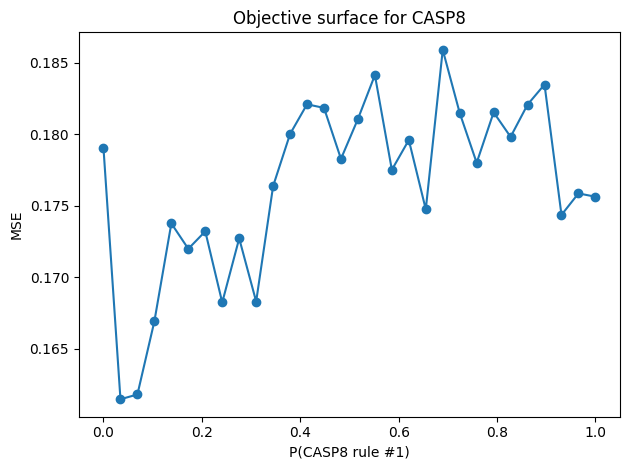

In [21]:
surface_scan(['CASP8'], 30)

Scanning 1-D surface over 30 steps …
Running step 1/30   MSE: 0.17687435570258508
Running step 2/30   MSE: 0.17595626150050736
Running step 3/30   MSE: 0.1784959562524221
Running step 4/30   MSE: 0.17976434529655005
Running step 5/30   MSE: 0.1774255181475853
Running step 6/30   MSE: 0.18226059038691853
Running step 7/30   MSE: 0.18067860535142474
Running step 8/30   MSE: 0.18247937175774281
Running step 9/30   MSE: 0.1717902798377648
Running step 10/30   MSE: 0.187443752403064
Running step 11/30   MSE: 0.17474096876712894
Running step 12/30   MSE: 0.18417383327298423
Running step 13/30   MSE: 0.1703358175176981
Running step 14/30   MSE: 0.18191078472194377
Running step 15/30   MSE: 0.1855747071794256
Running step 16/30   MSE: 0.18488389475971698
Running step 17/30   MSE: 0.18378063491904698
Running step 18/30   MSE: 0.18451399165075297
Running step 19/30   MSE: 0.19861832346171357
Running step 20/30   MSE: 0.18372191879618663
Running step 21/30   MSE: 0.1933686993172791
Running step 2

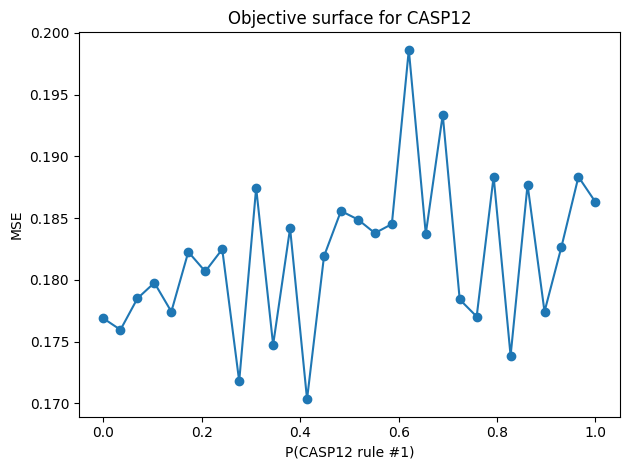

In [3]:
surface_scan(['CASP12'], 30)

Scanning 1-D surface over 30 steps …
Running step 1/30   MSE: 0.17663268733875004
Running step 2/30   MSE: 0.18655129772540469
Running step 3/30   MSE: 0.17548512798249413
Running step 4/30   MSE: 0.1949364858597939
Running step 5/30   MSE: 0.17581643290553167
Running step 6/30   MSE: 0.1906324560702387
Running step 7/30   MSE: 0.18558656672618037
Running step 8/30   MSE: 0.18028594640648682
Running step 9/30   MSE: 0.1747837360985095
Running step 10/30   MSE: 0.18060210008605382
Running step 11/30   MSE: 0.19715988223919986
Running step 12/30   MSE: 0.19102808875838873
Running step 13/30   MSE: 0.1916690140575818
Running step 14/30   MSE: 0.18779221436231822
Running step 15/30   MSE: 0.1772368837186074
Running step 16/30   MSE: 0.1897498964376322
Running step 17/30   MSE: 0.17483057083911624
Running step 18/30   MSE: 0.19404331745939468
Running step 19/30   MSE: 0.19250213793695417
Running step 20/30   MSE: 0.19171774029922928
Running step 21/30   MSE: 0.19016695553169066
Running step

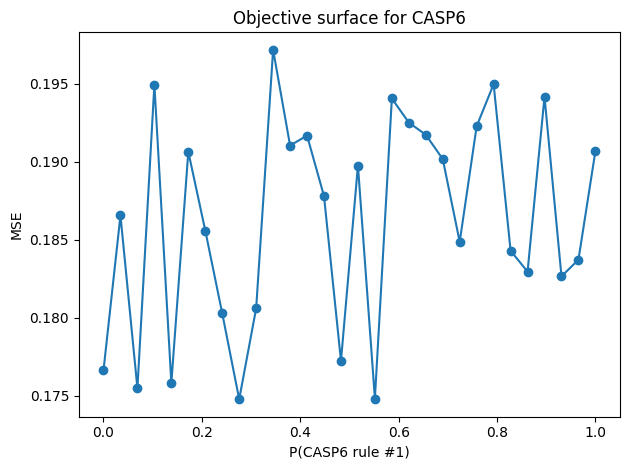

In [4]:
surface_scan(['CASP6'], 30)

Scanning 1-D surface over 30 steps …
Running step 1/30   MSE: 0.1993570141354172
Running step 2/30   MSE: 0.1905297656062228
Running step 3/30   MSE: 0.19844601925989727
Running step 4/30   MSE: 0.17723367687612268
Running step 5/30   MSE: 0.18981605146668984
Running step 6/30   MSE: 0.19557490506490613
Running step 7/30   MSE: 0.1859222656439617
Running step 8/30   MSE: 0.18539908867148525
Running step 9/30   MSE: 0.196615557074195
Running step 10/30   MSE: 0.19922464250427366
Running step 11/30   MSE: 0.1772612815493604
Running step 12/30   MSE: 0.18360549745014926
Running step 13/30   MSE: 0.19370599243100456
Running step 14/30   MSE: 0.1971628659338783
Running step 15/30   MSE: 0.1733182701916543
Running step 16/30   MSE: 0.19776850121636974
Running step 17/30   MSE: 0.17771183783049227
Running step 18/30   MSE: 0.19563310553553148
Running step 19/30   MSE: 0.1776959026963614
Running step 20/30   MSE: 0.18621835639524537
Running step 21/30   MSE: 0.17900472069274054
Running step 22

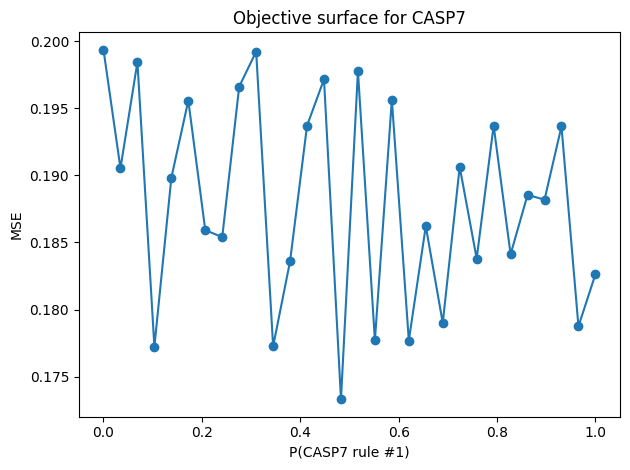

In [5]:
surface_scan(['CASP7'], 30)

Scanning 1-D surface over 30 steps …
Running step 1/30   MSE: 0.21739895734584933
Running step 2/30   MSE: 0.21483344421311631
Running step 3/30   MSE: 0.21249527318612413
Running step 4/30   MSE: 0.21201373352562722
Running step 5/30   MSE: 0.20686173330736687
Running step 6/30   MSE: 0.2101814713023444
Running step 7/30   MSE: 0.20427303041670006
Running step 8/30   MSE: 0.2026053521095366
Running step 9/30   MSE: 0.20083817245078128
Running step 10/30   MSE: 0.2013271142220432
Running step 11/30   MSE: 0.20139291295751124
Running step 12/30   MSE: 0.2020292652089131
Running step 13/30   MSE: 0.19228277758786347
Running step 14/30   MSE: 0.19176350259445726
Running step 15/30   MSE: 0.19795308978859527
Running step 16/30   MSE: 0.19376499077326093
Running step 17/30   MSE: 0.19264931119117437
Running step 18/30   MSE: 0.19906251487338117
Running step 19/30   MSE: 0.18389189877075904
Running step 20/30   MSE: 0.18108969157132443
Running step 21/30   MSE: 0.1912639043501236
Running ste

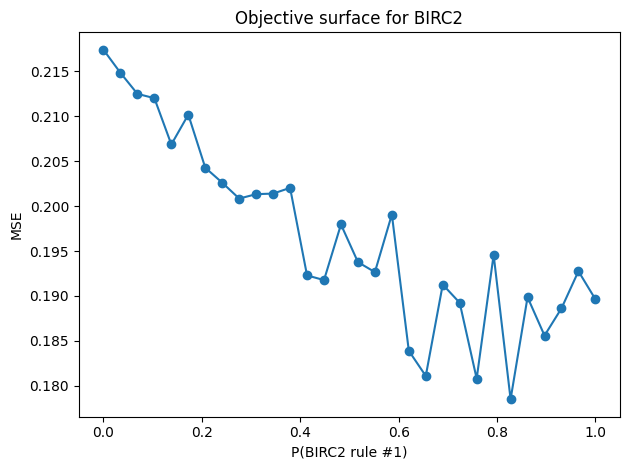

In [6]:
surface_scan(['BIRC2'], 30)

In [ ]:
surface_scan(['CASP8', 'CASP12'], 20)

In [ ]:
surface_scan(['CASP6', 'CASP7'], 20)

# Optimize top 5 sensitive nodes

In [12]:
from Optimizer.parameter_optimizer import ParameterOptimizer
config = {
    'de_params': {
        'strategy': 'best1bin',
        'maxiter': 100,
        'popsize': 40,
        'tol': 0.0001, 
        'atol': 0,
        'mutation': (0.5, 1),
        'recombination': 0.7,
        'seed': None,
        'disp': False,
        'init': 'sobol',
        'updating': 'deferred',
        'workers': -1,
        'early_stopping': False  # Control early stopping
    },
    'steady_state': {
        'method': 'monte_carlo',
            'monte_carlo_params': {
                'n_runs': 3,
                'n_steps': 5000,
                'p_noise': 0.05
            }
    },
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.2, # threshold for accepting fit,
    'display_rules_every': 5  # Display optimized rules every n iterations (0 = disabled)
}

In [ ]:
optimizer_top5 = ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned.csv', 
    config=config, 
    nodes_to_optimize=['CASP8','CASP12','CASP6','CASP7','BIRC2'], 
    verbose=True)
result_top5 = optimizer_top5.optimize(method='differential_evolution')


Optimization attempt 1/2
Running DE optimization...


DE Setup:
  - Max iterations: 100
  - Population size: 40
  - Tolerance: 0.0001
  - Absolute tolerance: 0
  - Mutation: (0.5, 1)
  - Recombination: 0.7
{'strategy': 'best1bin', 'maxiter': 100, 'popsize': 40, 'tol': 0.0001, 'atol': 0, 'mutation': (0.5, 1), 'recombination': 0.7, 'seed': None, 'disp': False, 'init': 'sobol', 'updating': 'deferred', 'workers': -1}
Iteration 1: Current MSE: 0.151918, Best MSE so far: 0.151918, Convergence: 0.0018
Iteration 2: Current MSE: 0.147587, Best MSE so far: 0.147587, Convergence: 0.0021
Iteration 3: Current MSE: 0.154001, Best MSE so far: 0.147587, Convergence: 0.0023
Iteration 4: Current MSE: 0.153338, Best MSE so far: 0.147587, Convergence: 0.0024
DE Iter 5: Best MSE: 0.143100 - Time: 14112.0s
  Current optimized rules:
    CASP8: complexIIB | complexIIA | CASP6 (p=0.005) | CASP8 (p=0.995)
    CASP12: CASP7 (p=0.645) | CASP12 (p=0.355)
    CASP6: ! BIRC2 | CASP3 (p=0.005) | CASP6 (p=0.995)
   

# Optimize one at a time
## PSO

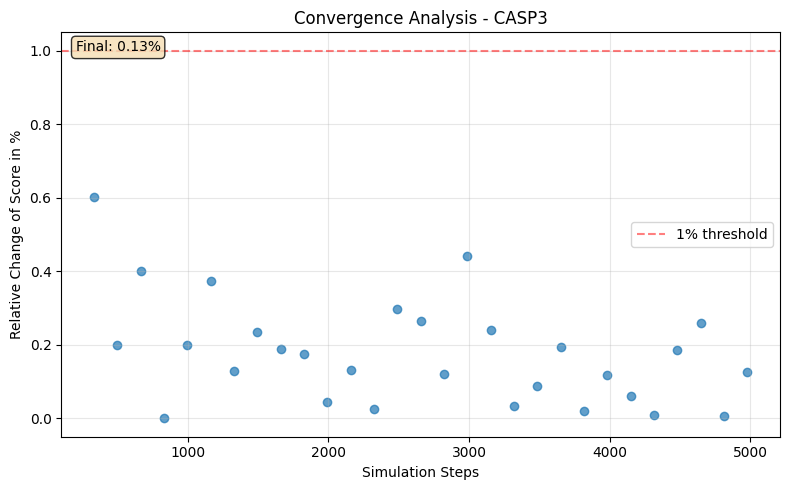

In [8]:
from BNMPy.steady_state import SteadyStateCalculator

calc = SteadyStateCalculator(pbn)
calc.set_experimental_conditions(stimuli=['EGF'],inhibitors=['JAK1'])
steady_state = calc.compute_steady_state(method='monte_carlo',n_runs=3,n_steps=5000,p_noise=0.05,analyze_convergence=True,output_node='CASP3')

In [3]:
# Configure optimizer
from Optimizer.parameter_optimizer import ParameterOptimizer
config = {
    'pso_params': {
        'n_particles': 20,  # 20*number of parameters to optimize
        'iters': 100,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': 0.00001,
        'ftol_iter': 10
    },
    'steady_state': {
        'method': 'monte_carlo',
            'monte_carlo_params': {
                'n_runs': 3,
                'n_steps': 5000,
                'p_noise': 0.05
            }
    },
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 1, # threshold for accepting fit,
    'display_rules_every': 0  # Display optimized rules every n iterations (0 = disabled)
}

In [4]:
optimizer = ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned.csv', 
    config=config, 
    nodes_to_optimize=['CASP12'], 
    verbose=True)
result = optimizer.optimize(method='particle_swarm')

2025-07-21 00:29:17,148 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Optimization attempt 1/2
Running PSO optimization...


PSO Setup:
  - Particles: 20
  - Max iterations: 100
  - Problem dimensions: 2
  - Total function evaluations: 2000
  Early stopping enabled:
    - Function tolerance: 1e-05
    - Tolerance iterations: 10


pyswarms.single.global_best:  18%|█▊        |18/100, best_cost=0.17
2025-07-21 05:08:28,559 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.16981813567427637, best pos: [0.57844093 0.83326049]


Success threshold achieved: 0.169818 < 1


In [5]:
optimizer = ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned.csv', 
    config=config, 
    nodes_to_optimize=['CASP8'], 
    verbose=True)
result = optimizer.optimize(method='particle_swarm')

2025-07-21 05:08:28,576 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Optimization attempt 1/2
Running PSO optimization...


PSO Setup:
  - Particles: 20
  - Max iterations: 100
  - Problem dimensions: 2
  - Total function evaluations: 2000
  Early stopping enabled:
    - Function tolerance: 1e-05
    - Tolerance iterations: 10


pyswarms.single.global_best:  18%|█▊        |18/100, best_cost=0.164
2025-07-21 09:48:05,060 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.16381141780913275, best pos: [0.01749436 0.52216941]


Success threshold achieved: 0.163811 < 1


In [13]:
pbn_string = optimizer.get_pbn_rules_string()
print(pbn_string)

AKT1 = AktM & AktP, 0.9900
AKT1 = AKT1, 0.0100
APAF1 = TP53, 0.9900
APAF1 = APAF1, 0.0100
APC = APAF1 & CASP9 & Mito | ! BIRC2, 0.9900
APC = APC, 0.0100
AktM = PDPK1 & PIP3, 0.9900
AktM = AktM, 0.0100
AktP = PDPK1 & PIP3, 0.9900
AktP = AktP, 0.0100
BAD = TP53 | ! RPS6KA1 | ! AKT1, 0.9900
BAD = BAD, 0.0100
BCL2L1 = ! TP53 | STAT3 | NFKB1 | ! BAD, 0.9900
BCL2L1 = BCL2L1, 0.0100
BID = MAPK8 & TP53 | CASP8 & TP53 | ! BCL2L1, 0.9900
BID = BID, 0.0100
BIRC2 = ! CASP3 & ! CASP6 | NFKB1 | ! Mito, 0.9900
BIRC2 = BIRC2, 0.0100
CASP12 = CASP7, 0.4549
CASP12 = CASP12, 0.5451
CASP3 = ! BIRC2 | CASP8 | CASP6 | APC, 0.9900
CASP3 = CASP3, 0.0100
CASP6 = ! BIRC2 | CASP3, 0.0261
CASP6 = CASP6, 0.9739
CASP7 = ! BIRC2 | CASP8 | APC, 0.9900
CASP7 = CASP7, 0.0100
CASP8 = complexIIB | complexIIA | CASP6, 0.7423
CASP8 = CASP8, 0.2577
CASP9 = ! BIRC2 | ! MAPK1 | CASP3 | CASP12 | ! AKT1, 0.9900
CASP9 = CASP9, 0.0100
CFLAR = NFKB1, 0.9900
CFLAR = CFLAR, 0.0100
EGF = EGF, 1.0000
EGFR = EGF, 1.0000
IKBKB = complex

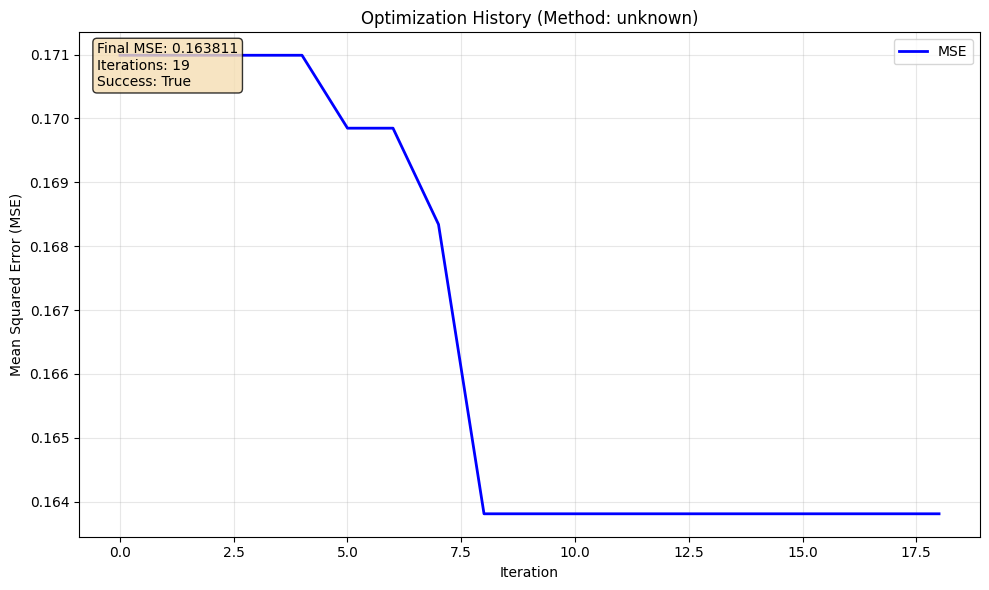

In [22]:
optimizer.plot_optimization_history(result)

In [ ]:
optimizer = ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned.csv', 
    config=config, 
    nodes_to_optimize=['CASP6'], 
    verbose=True)
result = optimizer.optimize(method='particle_swarm')

In [ ]:
optimizer = ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned.csv', 
    config=config, 
    nodes_to_optimize=['CASP7'], 
    verbose=True)
result = optimizer.optimize(method='particle_swarm')

2025-07-20 13:09:44,561 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Running optimization using method: particle_swarm
Maximum attempts: 2

--- Attempt 1/2 ---
PSO early stopping enabled:
  - Function tolerance: 1e-05
  - Tolerance iterations: 10


PSO Setup:
  - Particles: 20
  - Max iterations: 100
  - Problem dimensions: 2
  - Total function evaluations: 2000



pyswarms.single.global_best:   0%|          |0/100

## DE

In [8]:
importlib.reload(sys.modules['Optimizer.parameter_optimizer'])
from Optimizer.parameter_optimizer import ParameterOptimizer
config = {
    'de_params': {
        'strategy': 'best1bin',
        'maxiter': 100,
        'popsize': 30,
        'tol': 0.0001, 
        'atol': 0,
        'mutation': (0.5, 1),
        'recombination': 0.7,
        'seed': None,
        'disp': False,
        'init': 'sobol',
        'updating': 'deferred',
        'workers': -1,
        'early_stopping': False  # Control early stopping
    },
    'steady_state': {
        'method': 'monte_carlo',
            'monte_carlo_params': {
                'n_runs': 3,
                'n_steps': 5000,
                'p_noise': 0.05
            }
    },
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.2, # threshold for accepting fit,
    'display_rules_every': 0  # Display optimized rules every n iterations (0 = disabled)
}

In [9]:
optimizer = ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned.csv', 
    config=config, 
    nodes_to_optimize=['CASP8'], 
    verbose=True)
result = optimizer.optimize(method='differential_evolution')


Optimization attempt 1/2
Running DE optimization...


DE Setup:
  - Max iterations: 100
  - Population size: 30
  - Tolerance: 0.0001
  - Absolute tolerance: 0
  - Mutation: (0.5, 1)
  - Recombination: 0.7
{'strategy': 'best1bin', 'maxiter': 100, 'popsize': 30, 'tol': 0.0001, 'atol': 0, 'mutation': (0.5, 1), 'recombination': 0.7, 'seed': None, 'disp': False, 'init': 'sobol', 'updating': 'deferred', 'workers': -1}
Iteration 1: Current MSE: 0.187260, Best MSE so far: 0.187260, Convergence: 0.0036
Iteration 2: Current MSE: 0.184141, Best MSE so far: 0.184141, Convergence: 0.0036
Iteration 3: Current MSE: 0.175985, Best MSE so far: 0.175985, Convergence: 0.0042
Iteration 4: Current MSE: 0.178717, Best MSE so far: 0.175985, Convergence: 0.0046
Iteration 5: Current MSE: 0.189290, Best MSE so far: 0.175985, Convergence: 0.0048
Iteration 6: Current MSE: 0.189763, Best MSE so far: 0.175985, Convergence: 0.0050
Iteration 7: Current MSE: 0.167984, Best MSE so far: 0.167984, Convergence: 0.0058
I

In [10]:
pbn_string = optimizer.get_pbn_rules_string()
print(pbn_string)

AKT1 = AktM & AktP, 0.9900
AKT1 = AKT1, 0.0100
APAF1 = TP53, 0.9900
APAF1 = APAF1, 0.0100
APC = APAF1 & CASP9 & Mito | ! BIRC2, 0.9900
APC = APC, 0.0100
AktM = PDPK1 & PIP3, 0.9900
AktM = AktM, 0.0100
AktP = PDPK1 & PIP3, 0.9900
AktP = AktP, 0.0100
BAD = TP53 | ! RPS6KA1 | ! AKT1, 0.9900
BAD = BAD, 0.0100
BCL2L1 = ! TP53 | STAT3 | NFKB1 | ! BAD, 0.9900
BCL2L1 = BCL2L1, 0.0100
BID = MAPK8 & TP53 | CASP8 & TP53 | ! BCL2L1, 0.9900
BID = BID, 0.0100
BIRC2 = ! CASP3 & ! CASP6 | NFKB1 | ! Mito, 0.9900
BIRC2 = BIRC2, 0.0100
CASP12 = CASP7, 0.9900
CASP12 = CASP12, 0.0100
CASP3 = ! BIRC2 | CASP8 | CASP6 | APC, 0.9900
CASP3 = CASP3, 0.0100
CASP6 = ! BIRC2 | CASP3, 0.9900
CASP6 = CASP6, 0.0100
CASP7 = ! BIRC2 | CASP8 | APC, 0.9900
CASP7 = CASP7, 0.0100
CASP8 = complexIIB | complexIIA | CASP6, 0.0040
CASP8 = CASP8, 0.9960
CASP9 = ! BIRC2 | ! MAPK1 | CASP3 | CASP12 | ! AKT1, 0.9900
CASP9 = CASP9, 0.0100
CFLAR = NFKB1, 0.9900
CFLAR = CFLAR, 0.0100
EGF = EGF, 1.0000
EGFR = EGF, 0.9900
EGFR = EGFR, 0.

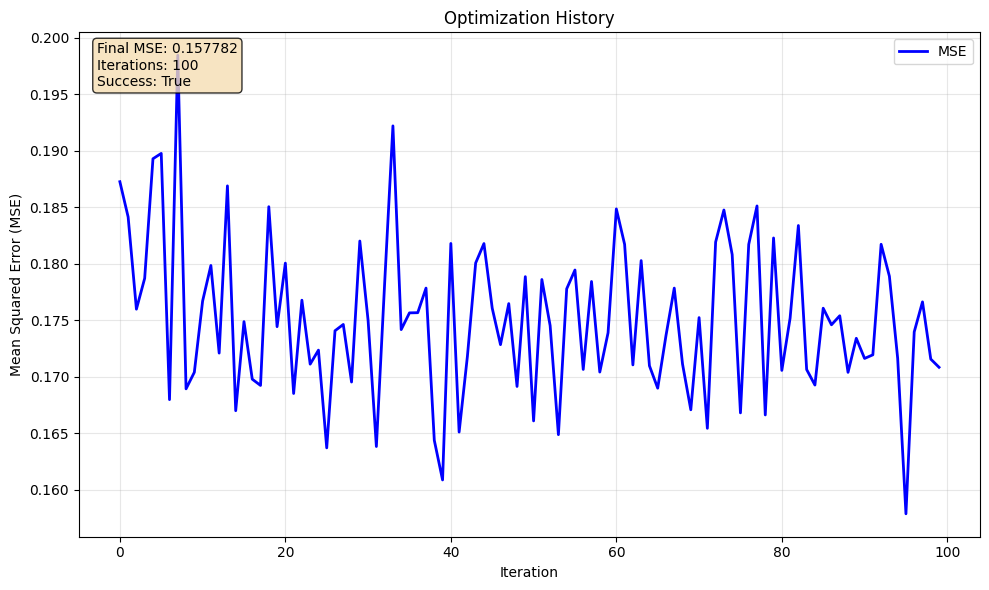

In [11]:
optimizer.plot_optimization_history(result)